# Proyecto 2. Modelos de clasificación supervisada para evaluar la calidad de un automovil

## Integrantes:
Daniel Enrique Granados Iglesias

# 1. Importación de paquetes

In [75]:
# Importar Matplotlib y Seaborn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Importar Pandas y NumPy.
import pandas as pd
import numpy as np
!pip show openpyxl

# Importar Warnings
import warnings
warnings.filterwarnings('ignore')

# Paquetes estadísticos
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn import datasets, metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


Name: openpyxl
Version: 3.1.2
Summary: A Python library to read/write Excel 2010 xlsx/xlsm files
Home-page: https://openpyxl.readthedocs.io
Author: See AUTHORS
Author-email: charlie.clark@clark-consulting.eu
License: MIT
Location: C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages
Requires: et-xmlfile
Required-by: 


# 2. Lectura de los datos

In [42]:
datos = pd.read_excel('car.data.xlsx')

# 3. Análisis preliminar de los datos

El objetivo de este proyecto es evaluar la calidad de un grupo de automóviles, a partir de ciertas características de estos.para utilizar una base que a partir de ciertas características de estos. Las variables a tener en cuenta son:

## Variables predictoras - features
* buying: precio de compra
* maint: precio de mantenimiento
* doors: número de pueras
* capacity: capacidad del vehículo en términos de personas que se pueden transportar
* lug_boot: el tamaño del maletero
* seguridad: seguridad estimada del vehículo

## Variable de respuesta - target
* class: nivel de evaluación para la calidad del vehículo

A continuación, un análisis preliminar de los datos:

In [43]:
datos.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [9]:
print('El número de filas del set de datos es: ', datos.shape[0])
print('Se tiene un total de ', datos.shape[1], ' variables')

El número de filas del set de datos es:  1728
Se tiene un total de  7  variables


In [10]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


Tal y como observamos, no tenemos variables con valores nulos, y todas las variables son de tipo object o categóricas.

Una buena forma de proceder con la modelación de los datos, es examinarlos de manera visual a través de gráficas. En este caso, examinaramos las frecuencias de las clases de cada variable a través de un gráfico de barras, pues estamos ante variables categóricas.

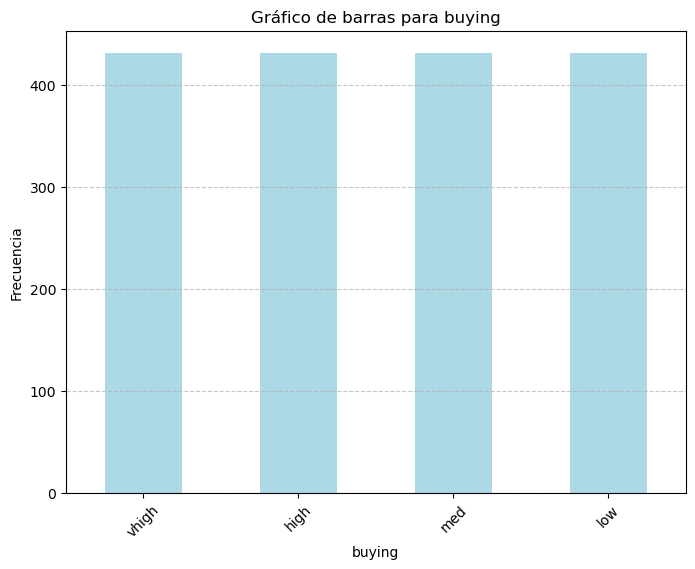

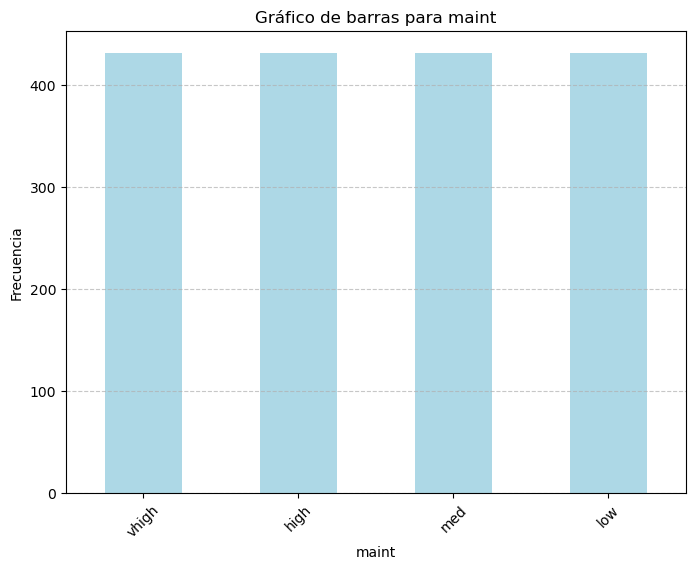

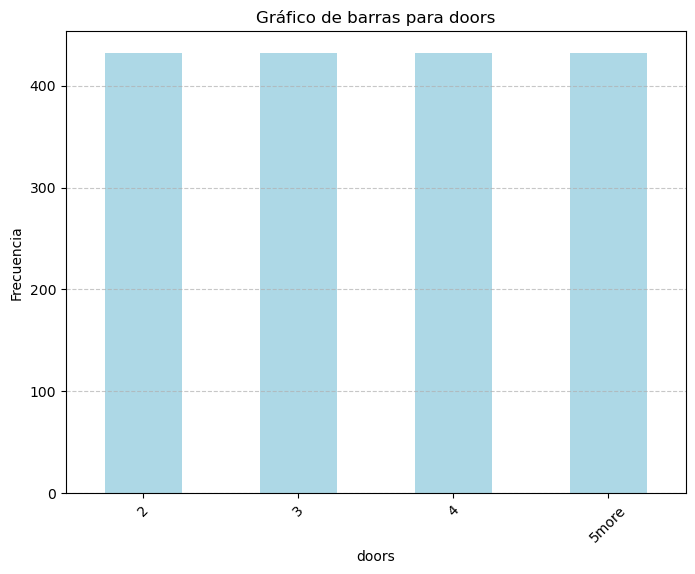

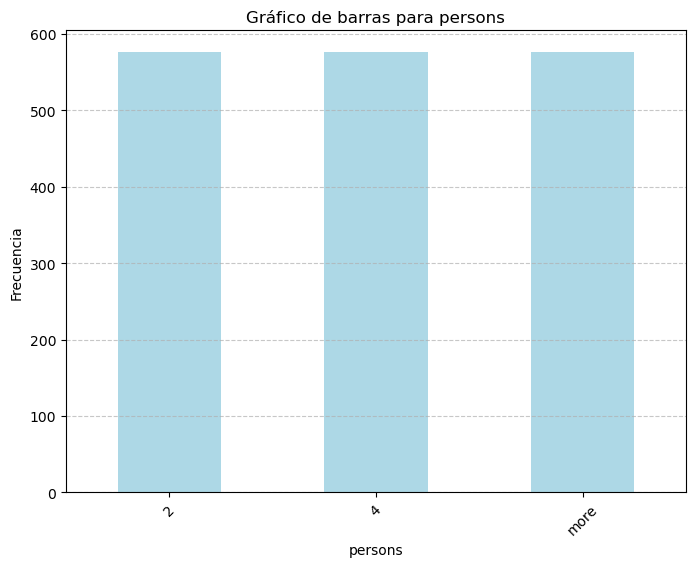

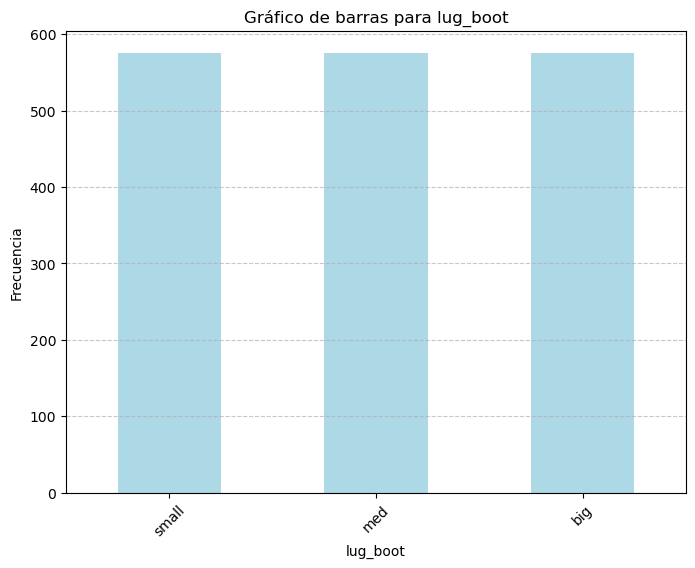

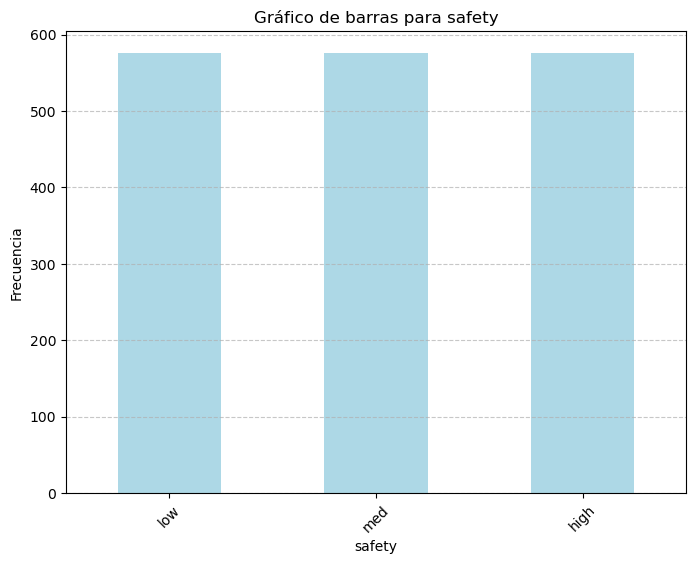

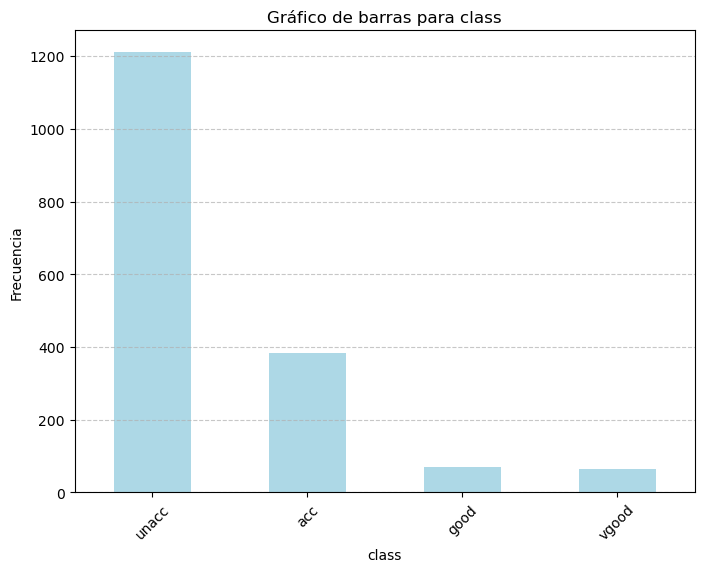

In [13]:
# Configuración del color
color = 'lightblue'

# Iterar sobre cada variable categórica y hacer un gráfico de barras
for variable in list(datos.columns):
    plt.figure(figsize=(8, 6))  # Tamaño del gráfico
    datos[variable].value_counts().plot(kind='bar', color=color)  # Conteo de valores y gráfico de barras
    plt.title(f'Gráfico de barras para {variable}')  # Título del gráfico
    plt.xlabel(variable)  # Etiqueta del eje x
    plt.ylabel('Frecuencia')  # Etiqueta del eje y
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Mostrar una cuadrícula horizontal
    plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor legibilidad
    plt.show()  # Mostrar el gráfico

Es curioso observar que se tiene el mismo número de datos para cada una de las categorías de las variables predictoras categóricas. No obstante, esto no ocurre para la variable objetivo 'class', donde ciertas clases evidentemente tienen más registros que las demás.

# 4. Tratamiento de los datos

Es importante considerar que, antes de construir cualquier modelo de predicción, las variables categóricas deberían ser transformadas a numéricas. A grosso modo, tenemos las siguientes dos formas de codificar nuestras variables numéricamente:

1. Codificación Numérica (Label Encoding): Esta técnica consiste en asignar un número único a cada categoría en una variable categórica. Por ejemplo, si tenemos una variable categórica llamada "Estrato" con categorías "Bajo", "Medio" y "Alto", podríamos asignar los números 0, 1 y 2 a estas categorías, respectivamente. Sin embargo, es importante destacar que al hacer esto, el algoritmo de aprendizaje puede interpretar que hay algún tipo de orden o jerarquía en las categorías, lo cual podría no ser válido en muchos casos.

2. One-Hot Encoding: Esta técnica crea nuevas columnas binarias (variables dummy) para cada categoría en la variable categórica original. Cada columna representa una categoría y tiene un valor de 1 si la observación pertenece a esa categoría y 0 en caso contrario. Esto evita la interpretación errónea de algún tipo de orden o jerarquía entre las categorías y es ampliamente utilizada en algoritmos de aprendizaje automático.

En este caso particular, todas las variables pudieran considerarse de tipo ordinal, pues hay un orden intrínseco en estas. Por ejemplo, para las variables buying y maint, la categoría "high" es de un orden superior a la categoría "med". Lo mismo ocurre para el resto de variables. Por lo anterior, en este caso utilizaremos la codificación numérica (label encoding) como sigue:

In [45]:
orden_buying = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}
orden_maint = {'low': 0, 'med': 1, 'high': 2, 'vhigh': 3}
orden_doors = {2: 0, 3: 1, 4: 2, '5more': 3}
orden_persons = {2: 0, 4: 1, 'more': 2}
orden_lug_boot = {'small': 0, 'med': 1, 'big': 2}
orden_safety = {'low': 0, 'med': 1, 'high': 2}
orden_class = {'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3}

# Reemplazamos
datos['buying'] = datos['buying'].replace(orden_buying)
datos['maint'] = datos['maint'].replace(orden_maint)
datos['doors'] = datos['doors'].replace(orden_doors)
datos['persons'] = datos['persons'].replace(orden_persons)
datos['lug_boot'] = datos['lug_boot'].replace(orden_lug_boot)
datos['safety'] = datos['safety'].replace(orden_safety)
datos['class'] = datos['class'].replace(orden_class)

In [46]:
datos['persons'].value_counts()

persons
0    576
1    576
2    576
Name: count, dtype: int64

# 5. División de los datos

Inicialmente, dividimos los datos en variables predictoras, y variable de respuesta, como sigue:

In [47]:
X = datos.drop(columns=['class'])
y = datos['class']

Finalmente, dividimos los datos en train y test, utilizando el 20% de las observaciones en la muestra de test.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [93]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# 6. Modelo de regresión logística

## 6.1. Entrenamiento del modelo

In [118]:
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)

LogisticRegression()

## 6.2. Evaluación del modelo

### 6.2.1. Matriz de confusión

In [120]:
ypred = reg_log.predict(X_test)
conf_matrix = confusion_matrix(y_test, ypred)

print ("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[218  14   1   2]
 [ 35  46   1   1]
 [  1   5   4   1]
 [  0   4   0  13]]


También podemos representar esta matriz a través de un mapa de calor, como sigue:

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

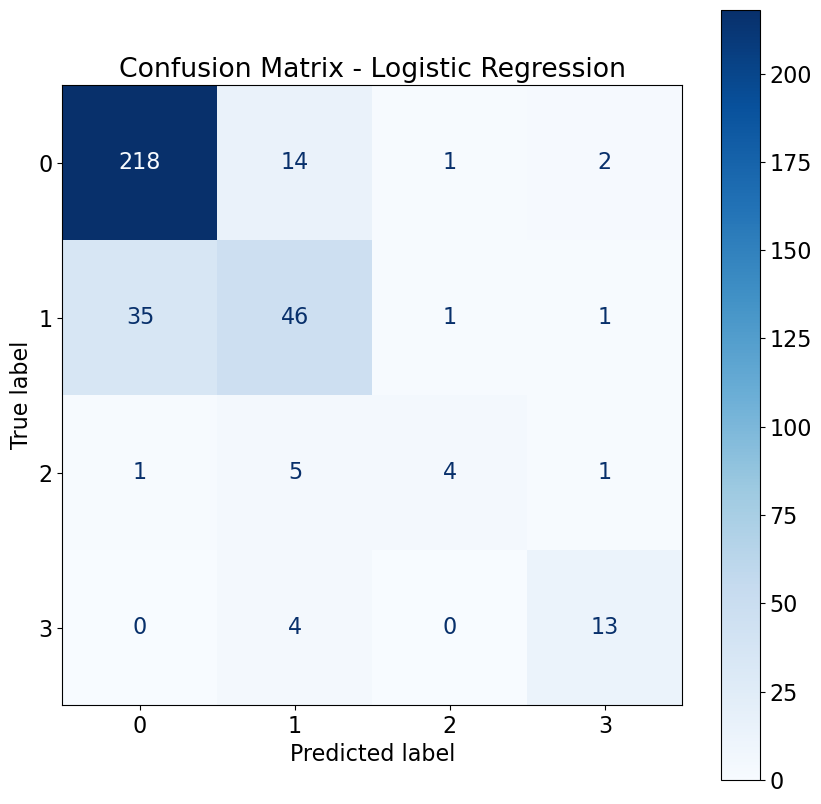

In [121]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay.from_estimator(reg_log,
                                             X_test,
                                             y_test,
                                             display_labels=reg_log.classes_,
                                             cmap=plt.cm.Blues,
                                             ax=axes
                                             )
disp.ax_.set_title('Confusion Matrix - Logistic Regression')

### 6.2.2. Métricas de desempeño

Calculamos las diferentes métricas del modelo, como sigue:

In [122]:
target_names = ['unacceptable', 'acceptable', 'good', 'very good']
print(classification_report(y_test, ypred, target_names=target_names))

              precision    recall  f1-score   support

unacceptable       0.86      0.93      0.89       235
  acceptable       0.67      0.55      0.61        83
        good       0.67      0.36      0.47        11
   very good       0.76      0.76      0.76        17

    accuracy                           0.81       346
   macro avg       0.74      0.65      0.68       346
weighted avg       0.80      0.81      0.80       346



In [123]:
error_reg_log=0
for i in range(0,len(y_test)):
    if(y_test[i]!=ypred[i]):
        error_reg_log+=1/len(y_test)
        
print('El error de clasificación para regresión logística en la muestra de test es:')
print(error_reg_log)

El error de clasificación para regresión logística en la muestra de test es:
0.1878612716763005


En general, podemos acceder al valor del Accuracy como sigue:

In [124]:
accuracy_reg_log = reg_log.score(X_test, y_test)
accuracy_reg_log

0.8121387283236994

Tal y como observamos, el accuracy del modelo es del 81.21%, un valor bastante bueno. Procederemos a comparar este valor con otros modelos de clasificación.

# 7. Modelo LDA -Análisis de Discriminante Lineal

## 7.1. Entrenamiento del modelo

In [125]:
clfLDA = LinearDiscriminantAnalysis()
clfLDA.fit(X_train, y_train)

LinearDiscriminantAnalysis()

## 7.2. Desempeño del modelo

In [126]:
prediccionesLDA=clfLDA.predict(X_test)
prediccionesProbLDA=clfLDA.predict_proba(X_test)

In [166]:
error_LDA=0
for i in range(0,len(y_test)):
    if(y_test[i]!=prediccionesLDA[i]):
        error_LDA+=1/len(y_test)
        
print('El error de clasificación para LDA en la muestra de test es:')
print(error_LDA)

El error de clasificación para LDA en la muestra de test es:
0.20231213872832363


In [128]:
accuracy_LDA = clfLDA.score(X_test, y_test)
print('El accuracy para LDA en la muestra de test es:')
print(accuracy_LDA)

El accuracy para LDA en la muestra de test es:
0.7976878612716763


# 8. Naive Bayes

## 8.1. Entrenamiento del modelo

In [135]:
clfNB = GaussianNB()
clfNB.fit(X_train, y_train)

GaussianNB()

## 8.2. Desempeño del modelo

In [136]:
prediccionesNB=clfNB.predict(X_test)
prediccionesProbNB=clfNB.predict_proba(X_test)

In [168]:
error_NB=0
for i in range(0,len(y_test)):
    if(y_test[i]!=prediccionesNB[i]):
        error_NB+=1/len(y_test)
        
print('El error de clasificación para Naive Bayes en la muestra de test es:')
print(error_NB)

El error de clasificación para Naive Bayes en la muestra de test es:
0.3179190751445092


In [138]:
accuracy_NB = clfNB.score(X_test, y_test)
print('El accuracy para NB en la muestra de test es:')
print(accuracy_NB)

El accuracy para NB en la muestra de test es:
0.6820809248554913


# 9. Modelo QDA

## 9.1. Entrenamiento del modelo

In [139]:
clfQDA = QuadraticDiscriminantAnalysis()
clfQDA.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

## 9.2. Desempeño del modelo

In [140]:
prediccionesQDA=clfQDA.predict(X_test)
prediccionesProbQDA=clfQDA.predict_proba(X_test)

In [170]:
error_QDA=0
for i in range(0,len(y_test)):
    if(y_test[i]!=prediccionesQDA[i]):
        error_QDA+=1/len(y_test)
        
print('El error de clasificación para QDA en la muestra de test es:')
print(error_QDA)

El error de clasificación para QDA en la muestra de test es:
0.9508670520231276


In [142]:
accuracy_QDA = clfQDA.score(X_test, y_test)
print('El accuracy para QDA en la muestra de test es:')
print(accuracy_QDA)

El accuracy para QDA en la muestra de test es:
0.049132947976878616


# 10. Random Forest Classifier

## 10.1. Entrenamiento del modelo

In [154]:
from sklearn.ensemble import RandomForestClassifier

In [155]:
# Definición de modelo Random Forest para un problema de clasificación
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

## 10.2. Desempeño del modelo

In [156]:
prediccionesRF=RF.predict(X_test)
prediccionesProbRF=RF.predict_proba(X_test)

In [172]:
error_RF=0
for i in range(0,len(y_test)):
    if(y_test[i]!=prediccionesRF[i]):
        error_RF+=1/len(y_test)
        
print('El error de clasificación para RF en la muestra de test es:')
print(error_RF)

El error de clasificación para RF en la muestra de test es:
0.028901734104046235


In [158]:
accuracy_RF = RF.score(X_test, y_test)
print('El accuracy para RF en la muestra de test es:')
print(accuracy_RF)

El accuracy para RF en la muestra de test es:
0.9710982658959537


# 11. Conclusiones

A continuación, elegiremos el mejor modelo tomando como criterio el accuracy o exactitud de predicción, y el error de predicción.

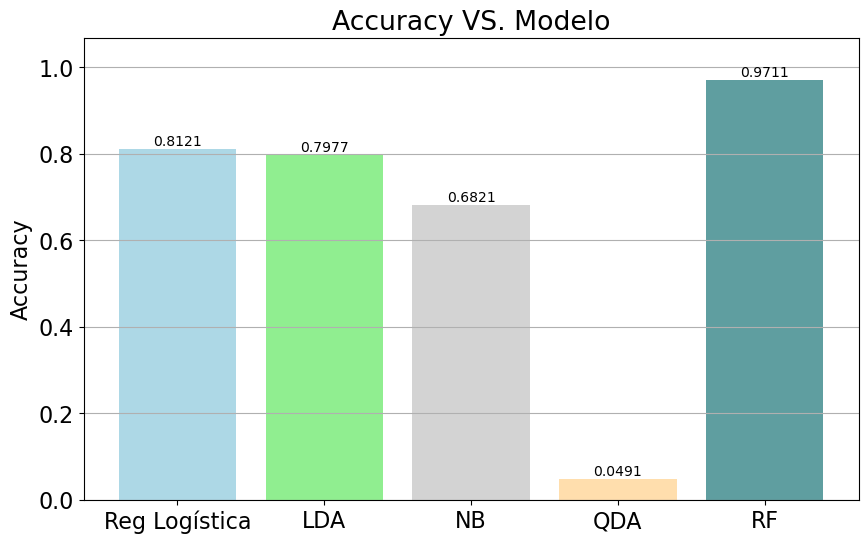

In [163]:
model_names = ['Reg Logística', 'LDA', 'NB', 'QDA', 'RF']
accuracy = [accuracy_reg_log, accuracy_LDA, accuracy_NB, accuracy_QDA, accuracy_RF]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy, color=['lightblue', 'lightgreen', 'lightgray', 'navajowhite', 'cadetblue'])

for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.4f}',
             ha='center', va='bottom', color='black', fontsize=10)

plt.ylabel('Accuracy')
plt.title('Accuracy VS. Modelo')
plt.ylim(0, max(accuracy) * 1.1)
plt.grid(axis='y')
plt.show()

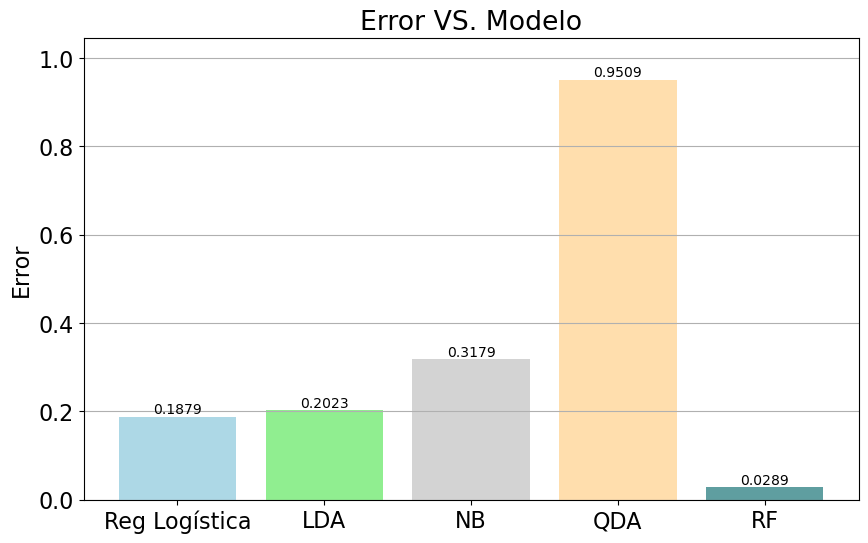

In [173]:
model_names = ['Reg Logística', 'LDA', 'NB', 'QDA', 'RF']
accuracy = [error_reg_log, error_LDA, error_NB, error_QDA, error_RF]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy, color=['lightblue', 'lightgreen', 'lightgray', 'navajowhite', 'cadetblue'])

for bar, acc in zip(bars, accuracy):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{acc:.4f}',
             ha='center', va='bottom', color='black', fontsize=10)

plt.ylabel('Error')
plt.title('Error VS. Modelo')
plt.ylim(0, max(accuracy) * 1.1)
plt.grid(axis='y')
plt.show()

Tal y como observamos, el mejor modelo para este escenario es el Random Forest Classifier, pues para este modelo obtenemos el mayor valor para el Accuracy, y el menor valor para el error de predicción. En ese orden de ideas, el modelo con peor desempeño es el QDA (Quadratic Discriminant Analysis).